# Solver

In [1]:
from pathlib import Path
import os
import copy

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

HERE = Path(os.getcwd()) # Path(__file__) won't work in Jupyter
HERE

PosixPath('/home/hangman/Documents/solver')

## Config file

Create yaml file and pass as command line argument.
Defaults to `config/settings.yaml`

`model`(str): Choose model from

- `vibration`
- `fall`

`init_acceleration`(float): Initial acceleration value.

`init_velocity`(float): Initial velocity value.

`init_position`(float): Initial position value.

`acc_fname`(str): Name of the acceleration file.

`vel_fname`(str): Name of the velocity file.

`pos_fname`(str): Name of the position file.

`model_params`(dict): Model parameters.

- `model` = "vibration"
  - `mass`(float): Mass of the object.
  - `spring`(float): Spring constant.
  - `amplitude`(float): Amplitude of external force.
  - `frequency`(float): Frequency of external force.
- `model` = "fall"
  - `mass`(float): Mass of the object.
  - `height`(float): Initial height from which the object is falling.


In [2]:
with open(HERE / 'config' / 'settings.yaml') as f:
    config = yaml.safe_load(f)
config

{'acc_fname': 'acceleration.csv',
 'init_acceleration': 0.0,
 'init_position': 0.0,
 'init_velocity': 0.0,
 'model': 'vibration',
 'model_params': {'amplitude': 5, 'frequency': 3, 'mass': 10, 'spring': 10},
 'pos_fname': 'position.csv',
 'time_end': 15,
 'time_step': 0.1,
 'vel_fname': 'velocity.csv'}

In [3]:
vib_config = {
    'model'            : 'vibration',
    'time_end'         : 15,
    'time_step'        : 0.001,
    'init_acceleration': 0.0,
    'init_velocity'    : 0.0,
    'init_position'    : 0.0,
    'acc_fname'        : 'acceleration.csv',
    'vel_fname'        : 'velocity.csv',
    'pos_fname'        : 'position.csv',
    'model_params': {
        "mass"     : 10,
        "spring"   : 10,
        "amplitude": 5,
        "frequency": 3,
    }
}
# with open(HERE / 'config' / 'vibration-tmp.yaml', 'w') as f:
#     yaml.dump(vib_config, f)

## Simulation

```bash
cargo run path/to/config.yaml
# cargo run #default-> config/settings.yaml
```

### Output

- `result/`
  - `<config["acc_fname"]>.csv`
  - `<config["velocity_fname"]>.csv`
  - `<config["pos_fname"]>.csv`


In [18]:
def run_sim(config: dict):
    config_path = HERE / "config" / "tmp.yaml"
    with open(config_path, "w") as f:
        yaml.dump(config, f)
    os.system(f"cargo run {config_path}")
    os.unlink(config_path)

## Results

### $a(t)$ (acceleration)

In [24]:
acc_df = pd.read_csv(
    HERE / 'result' / 'acceleration.csv'
)
# acc_df

### $v(t)$ (velocity: 1st integral)

In [23]:
vel_df = pd.read_csv(
    HERE / "result" / "velocity.csv",
)
# vel_df

### $x(t)$ (position: 2nd integral)

In [22]:
pos_df = pd.read_csv(
    HERE / "result" / "position.csv",
)
# pos_df

### Plot

In [15]:
def plot_axs(axs, df):
    axs.plot(
        df["timestamp"], df["euler"],
        label="euler",
        color="blue",
        linestyle="--"
    )
    axs.plot(
        df["timestamp"], df["rk4"],
        label="Runge-Kutta",
        color="orange",
        linestyle=":"
    )
    axs.legend()


def plot_all(acc_df, vel_df, pos_df):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    fig.suptitle('Simulation Results')

    plot_axs(axs[0], acc_df)
    axs[0].set_ylabel('Acceleration')

    plot_axs(axs[1], vel_df)
    axs[1].set_ylabel('Velocity')

    plot_axs(axs[2], pos_df)
    axs[2].set_ylabel('Position')

    plt.xlabel('Time (s)')
    plt.show()

In [21]:
# plot_all(acc_df, vel_df, pos_df)

## Lazy

In [19]:
def run_and_plot(config: dict):
    run_sim(config)
    acc_df = pd.read_csv(HERE / 'result' / config['acc_fname'])
    vel_df = pd.read_csv(HERE / 'result' / config['vel_fname'])
    pos_df = pd.read_csv(HERE / 'result' / config['pos_fname'])
    plot_all(acc_df, vel_df, pos_df)

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.19s
     Running `target/debug/solver /home/hangman/Documents/solver/config/tmp.yaml`


Vibration(Vibration { condition: SolverParam { time_end: 15.0, time_step: 0.001, init_acceleration: 0.0, init_velocity: 0.0, init_position: 0.0 }, mass: 10.0, spring: 10.0, amplitude: 5.0, frequency: 3.0 })

=== Final Values v(15) ===
Euler method:        67.207886
Runge-Kutta method:  66.714851

=== Integrals x(t) = ∫v(t)dt from 0 to 15 ===
Euler ODE + Trap integration:  52.553226
RK4 ODE + Trap integration:    51.480297



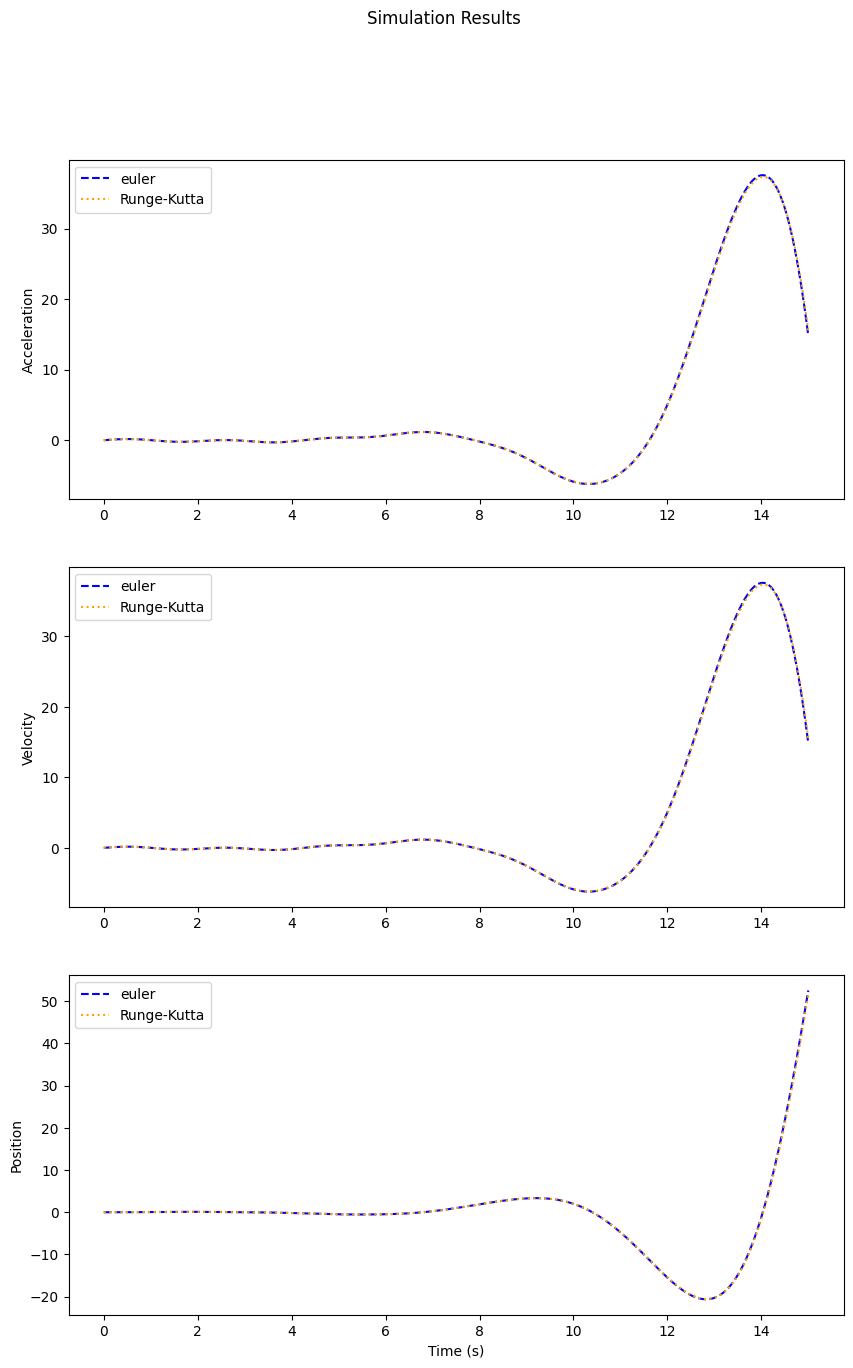

In [20]:
run_and_plot(
    {
        'model'            : 'vibration',
        'time_end'         : 15,
        'time_step'        : 0.001,
        'init_acceleration': 0.0,
        'init_velocity'    : 0.0,
        'init_position'    : 0.0,
        'acc_fname'        : 'acceleration.csv',
        'vel_fname'        : 'velocity.csv',
        'pos_fname'        : 'position.csv',
        'model_params': {
            "mass"     : 10,
            "spring"   : 10,
            "amplitude": 5,
            "frequency": 3,
        }
    }
)